In [1]:
from torch import nn
import torch
import numpy as np
import gpytorch

In [2]:
from scipy.spatial.distance import cdist

def squared_exponential_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """Compute the Squared Exponential (RBF) kernel between two sets of inputs."""
    sqdist = cdist(x1, x2, 'sqeuclidean')
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

np.random.seed(0)
torch.manual_seed(10)

# Training data is 200 points in [-7,7] inclusive regularly spaced
num_samples = 20  # Number of samples to generate
length_scale = 1.0  # Length scale of the SE kernel
sigma_f = 1.0  # Signal variance

# Generate input points and compute the covariance matrix using SE kernel
train_x = np.linspace(-7, 7, num_samples).reshape(-1, 1)
train_x_cov = squared_exponential_kernel(train_x, train_x, length_scale, sigma_f)
# Generate zero-mean Gaussian data with the computed covariance matrix
train_y = np.random.multivariate_normal(np.zeros(num_samples), train_x_cov) + 0.4 * np.random.randn(num_samples)

x_tensor = torch.tensor(train_x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(train_y, dtype=torch.float32)

num_test_samples = 200  # Number of samples to generate
# Generate input points and compute the covariance matrix using SE kernel
test_x = np.linspace(-12, 12, num_test_samples).reshape(-1, 1)
test_x_cov = squared_exponential_kernel(test_x, test_x, length_scale, sigma_f)
# Generate zero-mean Gaussian data with the computed covariance matrix
test_y = np.random.multivariate_normal(np.zeros(num_test_samples), test_x_cov) + 0.1 * np.random.randn(num_test_samples)

test_x_tensor = torch.tensor(test_x, dtype=torch.float32).view(-1, 1)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
gp_likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(x_tensor.squeeze(), y_tensor, gp_likelihood)

In [4]:
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.hidden(x)

In [5]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, x_tensor, y_tensor, likelihood):
            super(GPRegressionModel, self).__init__(x_tensor, y_tensor, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, 
                grid_size=32,
            )
            self.feature_extractor = DNN(input_dim=1, output_dim=2)

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
likelihood = gpytorch.likelihoods.GaussianLikelihood()
dkl_model = GPRegressionModel(x_tensor, y_tensor, likelihood)

In [6]:
from dak.utils.sparse_design.design_class import HyperbolicCrossDesign
from dak.kernels.laplace_kernel import LaplaceProductKernel
from dak.layers.functional import ScaleToBounds
from dak.layers.activation import Amk1d
from dak.layers.linear import LinearFlipout, LinearReparameterization

class DAKMC(nn.Module):
    def __init__(self, input_dim, output_dim, design_class, kernel):
        super(DAKMC, self).__init__()

        self.feature_extractor = DNN(input_dim=input_dim, output_dim=2)
        self.norm = nn.BatchNorm1d(2)
        self.mk1 = Amk1d(in_features=2, n_level=5, input_lb=-3., input_ub=3., design_class=design_class, kernel=kernel)
        self.gp1 = LinearFlipout(self.mk1.out_features, output_dim)

    def forward(self, x, return_kl=True):
        x = self.feature_extractor(x)
        x = self.norm(x)
        x = self.mk1(x).flatten(1)
        x, kl = self.gp1(x)
        if return_kl:
            return x, kl
        else:
            return x
        
dak_mc = DAKMC(input_dim=1, 
               output_dim=1, 
               design_class=HyperbolicCrossDesign, 
               kernel=LaplaceProductKernel(.3),
               )

In [7]:
class DAKCF(nn.Module):
    def __init__(self, input_dim, output_dim, design_class, kernel):
        super(DAKCF, self).__init__()

        self.feature_extractor = DNN(input_dim=input_dim, output_dim=2)
        self.norm = ScaleToBounds(-3., 3.)
        self.mk1 = Amk1d(in_features=2, n_level=5, input_lb=-3., input_ub=3., design_class=design_class, kernel=kernel)
        self.gp1 = LinearReparameterization(
            in_features=[self.mk1.in_features, self.mk1.num_inducing],
            out_features=output_dim,
        )

    def forward(self, x, return_kl=True):
        x = self.feature_extractor(x)
        x = self.norm(self.mk1(x))
        res, kl = self.gp1(x, return_sampling=False)
        if return_kl:
            return res, kl
        else:
            return res
        
dak_cf = DAKCF(input_dim=1, 
               output_dim=1, 
               design_class=HyperbolicCrossDesign, 
               kernel=LaplaceProductKernel(.3),
               )

In [8]:
def train_gpr(model, criterion, optimizer, epochs=200):
    losses = []
    for epoch in range(epochs):
        model.train()
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x_tensor)
        # Calc loss and backprop derivatives
        loss = - criterion(output, y_tensor)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')
            
    return losses

In [9]:
gp_optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.001)
gp_criterion = gpytorch.mlls.ExactMarginalLogLikelihood(gp_likelihood, gp_model)

gp_losses = train_gpr(gp_model, gp_criterion, gp_optimizer, epochs=500)

Epoch [0/500], Loss: 1.6272567510604858
Epoch [100/500], Loss: 1.5926620960235596
Epoch [200/500], Loss: 1.5580029487609863
Epoch [300/500], Loss: 1.5240381956100464
Epoch [400/500], Loss: 1.4914453029632568


In [10]:
# Use the adam optimizer
dkl_optimizer = torch.optim.Adam([
    {'params': dkl_model.feature_extractor.parameters()},
    {'params': dkl_model.covar_module.parameters(), 'lr': 0.001},
    {'params': dkl_model.mean_module.parameters(), 'lr': 0.001},
    {'params': dkl_model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
dkl_criterion = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, dkl_model)

dkl_losses = train_gpr(dkl_model, dkl_criterion, dkl_optimizer, epochs=500)

/home/wez/miniconda3/envs/dak/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_new.cpp:651.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Epoch [0/500], Loss: 1.7721397876739502
Epoch [100/500], Loss: 1.5856530666351318
Epoch [200/500], Loss: 1.297196626663208
Epoch [300/500], Loss: 0.9713412523269653
Epoch [400/500], Loss: 0.6670908331871033


In [11]:
# Training loop
def train_dak(model, criterion, optimizer, epochs=200, mc_sampling=True):
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        if mc_sampling:
            output_ = []
            kl_ = []
            for mc_run in range(4):
                output, kl = dak_mc(x_tensor)
                output_.append(output)
                kl_.append(kl)
            output = torch.mean(torch.stack(output_), dim=0)
            kl = torch.mean(torch.stack(kl_), dim=0)
            loss = criterion(output, y_tensor.view(-1,1)) + kl / len(train_x)
        else:
            mean_var, kl = dak_cf(x_tensor)
            output_mean = mean_var.mean
            output_var = mean_var.var
            loss = criterion(output_mean, y_tensor.view(-1,1), 0.1**2*torch.ones_like(output_mean)) + output_var.sum() + kl / len(train_x)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')
            
    return losses

In [12]:
dak_mc_optimizer = torch.optim.Adam(dak_mc.parameters(), lr=0.01)
dak_mc_criterion = nn.MSELoss()

dak_mc_losses = train_dak(dak_mc, dak_mc_criterion, dak_mc_optimizer, epochs=500)

Epoch [0/500], Loss: 2.404254674911499
Epoch [100/500], Loss: 0.2430257350206375
Epoch [200/500], Loss: 0.17881974577903748
Epoch [300/500], Loss: 0.1315390169620514
Epoch [400/500], Loss: 0.1105801910161972


In [13]:
def evaluate_gpr(model, x, likelihood):
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(x))
    
    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()
    
    return mean, lower.numpy(), upper.numpy()

In [14]:
gp_pred_mean, gp_pred_lower, gp_pred_upper = evaluate_gpr(gp_model, test_x_tensor, gp_likelihood)

In [15]:
dkl_pred_mean, dkl_pred_lower, dkl_pred_upper = evaluate_gpr(dkl_model, test_x_tensor, likelihood)

In [16]:
def evaluate_dak(model, x, mc_sampling=True):
    model.eval()
    
    with torch.no_grad():
        if mc_sampling:
            predicts = []
            for mc_run in range(10000):
                output = model(x, return_kl=False)
                predicts.append(output.cpu().data.numpy())
                
            pred_mean = np.mean(predicts, axis=0)
            pred_std = np.std(predicts, axis=0)
            lower = pred_mean - 2 * pred_std
            upper = pred_mean + 2 * pred_std
        else:
            mean_var = model(x, return_kl=False)
            pred_mean = mean_var.mean.cpu().numpy()
            pred_std = mean_var.var.cpu().data.numpy()
            lower = pred_mean - 2 * pred_std
            upper = pred_mean + 2 * pred_std
    
    return pred_mean, lower.squeeze(), upper.squeeze()

In [17]:
dak_mc_pred_mean, dak_mc_pred_lower, dak_mc_pred_upper = evaluate_dak(dak_mc, test_x_tensor)

In [18]:
from matplotlib import pyplot as plt

def plot(mean, lower, upper, legend=True, save_path=None):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot training data as black stars
    ax.plot(x_tensor.numpy(), y_tensor.numpy(), 'k*')
    
    # Plot predictive means as blue line
    ax.plot(test_x_tensor.numpy(), mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_tensor.numpy().squeeze(), lower, upper, alpha=0.5)
    ax.set_xlim([-12,12])
    ax.set_ylim([-4, 4])
    if legend:
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        
    plt.savefig(save_path)

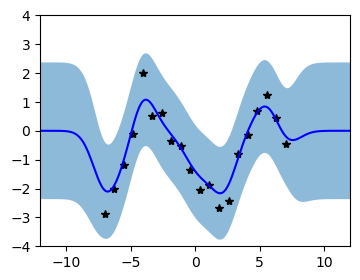

In [19]:
plot(gp_pred_mean, gp_pred_lower, gp_pred_upper, legend=False, save_path='results/toy_gp.pdf')

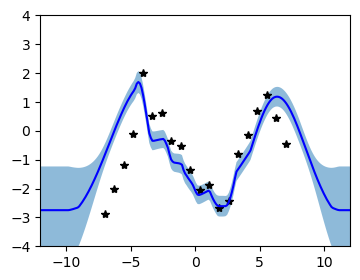

In [20]:
plot(dkl_pred_mean, dkl_pred_lower, dkl_pred_upper, legend=False, save_path='results/toy_dkl.pdf')

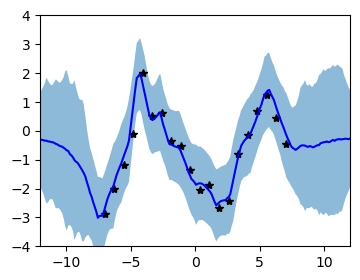

In [21]:
plot(dak_mc_pred_mean, dak_mc_pred_lower, dak_mc_pred_upper, legend=False, save_path='toy_dak_1.pdf')